In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [3]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "darkgrey",
    "family": "arial",
}

label_font = {
    "fontsize": 10,
    "family": "arial",
}

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
TRAIN_DATASET_PATH = 'datasets/course_project_train.csv'
TEST_DATASET_PATH = 'datasets/course_project_test.csv'
PREPARED_TRAIN_DATASET_PATH = 'datasets/course_project_train_prepared.csv'
PREPARED_TEST_DATASET_PATH = 'datasets/course_project_test_prepared.csv'

TRAIN_FULL_PATH = 'datasets/course_project_train_full.csv'
TRAIN_PART_PATH = 'datasets/course_project_train_part.csv'
VALID_PART_PATH = 'datasets/course_project_valid_part.csv'

SCALER_FILE_PATH = '../scaler.pkl'

#### Обзор обучающего датасета

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.shape

(7500, 17)

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### Обзор тестового датасета

In [12]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.shape

(2500, 16)

In [13]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [15]:
df_test.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Обработка выбросов

**Обучающий датасет**

In [16]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*Maximum Open Credit*

In [17]:
median_open_credit = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [18]:
median_loan_ammount = df_train['Current Loan Amount'].median()
df_train.loc[df_train['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [19]:
df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] / 10

**Тестовый датасет**

In [20]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


*Maximum Open Credit*

In [21]:
df_test.loc[df_test['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [22]:
df_test.loc[df_test['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [23]:
df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] = df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] / 10

### Обработка пропусков обучающего датасета

##### Annual Income

In [24]:
median_income = {}
for value in df_train['Years in current job'].unique():
    median_income[value] = df_train.loc[df_train['Years in current job'] == value, 'Annual Income'].median()
    
median_income

{nan: nan,
 '10+ years': 1327473.0,
 '8 years': 1249269.0,
 '6 years': 1155257.0,
 '7 years': 1159313.5,
 '5 years': 1137121.5,
 '1 year': 1023330.5,
 '< 1 year': 991477.0,
 '4 years': 1163968.5,
 '3 years': 1159494.0,
 '2 years': 1080492.0,
 '9 years': 1181306.0}

In [25]:
for i in df_train.index[df_train['Annual Income'].isnull()]:
    years = df_train.iloc[i, 2]
    df_train.iat[i, 1] = median_income[years]

In [26]:
#for i in df_train.index[df_train['Annual Income'].isnull()]:
 #   years = df_train.iloc[i, 2]
  #  df_train.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
   #     & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

In [27]:
med_anual_income = df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

In [28]:
job_years = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

In [29]:
credit_score = {}
for value in df_train['Home Ownership'].unique():
    credit_score[value] = df_train.loc[df_train['Home Ownership'] == value, 'Credit Score'].median()

credit_score

{'Own Home': 727.0,
 'Home Mortgage': 731.0,
 'Rent': 727.0,
 'Have Mortgage': 710.0}

In [30]:
for i in df_train.index[df_train['Credit Score'].isnull()]:
    home_ownership = df_train.iloc[i, 0]
    df_train.iat[i, 15] = credit_score[home_ownership]

In [31]:
# for i in df_train.index[df_train['Credit Score'].isnull()]:
#    home_ownership = df_train.iloc[i, 0]
#    df_train.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
#        & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

In [32]:
bankruptcies = {}
for value in df_train['Credit Score'].unique():
    bankruptcies[value] = df_train.loc[df_train['Credit Score'] == value, 'Bankruptcies'].median()

In [33]:
for i in df_train.index[df_train['Bankruptcies'].isnull()]:
    cred_score = df_train.iloc[i, 15]
    df_train.iat[i, 9] = bankruptcies[cred_score]

In [34]:
#for i in df_train.index[df_train['Bankruptcies'].isnull()]:
 #   credit_score = df_train.iloc[i, 15]
  #  df_train.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
   #     & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

In [35]:
delinquent_months = {}
for value in df_train['Bankruptcies'].unique():
    delinquent_months[value] = df_train.loc[df_train['Bankruptcies'] == value, 'Months since last delinquent'].median()

delinquent_months

{1.0: 46.0, 0.0: 31.0, 3.0: 67.0, 2.0: 50.5, 4.0: 78.0}

In [36]:
for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
    bankrupt = df_train.iloc[i, 9]
    df_train.iat[i, 8] = delinquent_months[bankrupt]

In [37]:
# for i in df_train.index[df_train['Months since last delinquent'].isnull()]:
#     bankruptcies = df_train.iloc[i, 9]
#     df_train.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
#         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

In [38]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Обработка пропусков тестового датасета

##### Annual Income

In [39]:
for i in df_test.index[df_test['Annual Income'].isnull()]:
    years = df_test.iloc[i, 2]
    df_test.iat[i, 1] = median_income[years]

In [40]:
#for i in df_test.index[df_train['Annual Income'].isnull()]:
 #   years = df_test.iloc[i, 2]
  #  df_test.iat[i, 1] = df_train.loc[(df_train['Years in current job'] == years)\
   #     & (~df_train['Years in current job'].isnull()), 'Annual Income'].median()

In [41]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

##### Years in current job

In [42]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = job_years

##### Credit Score

In [43]:
for i in df_test.index[df_test['Credit Score'].isnull()]:
    home_ownership = df_test.iloc[i, 0]
    df_test.iat[i, 15] = credit_score[home_ownership]

In [44]:
# for i in df_test.index[df_test['Credit Score'].isnull()]:
#    home_ownership = df_test.iloc[i, 0]
#    df_test.iat[i, 15] = df_train.loc[(df_train['Home Ownership'] == home_ownership)\
#        & (~df_train['Home Ownership'].isnull()), 'Credit Score'].median()

##### Bankruptcies

In [45]:
for i in df_test.index[df_test['Bankruptcies'].isnull()]:
    cred_score = df_test.iloc[i, 15]
    df_test.iat[i, 9] = bankruptcies[cred_score]

In [46]:
#for i in df_test.index[df_test['Bankruptcies'].isnull()]:
 #   credit_score = df_test.iloc[i, 15]
  #  df_test.iat[i, 9] = df_train.loc[(df_train['Credit Score'] == credit_score)\
   #     & (~df_train['Credit Score'].isnull()), 'Bankruptcies'].median()

##### Months since last delinquent

In [47]:
for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
    bankrupt = df_test.iloc[i, 9]
    df_test.iat[i, 8] = delinquent_months[bankrupt]

In [48]:
# for i in df_test.index[df_test['Months since last delinquent'].isnull()]:
#     bankruptcies = df_test.iloc[i, 9]
#     df_test.iat[i, 8] = df_train.loc[(df_train['Bankruptcies'] == bankruptcies)\
#         & (~df_train['Bankruptcies'].isnull()), 'Months since last delinquent'].median()

In [49]:
df_test.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Корреляционная матрица

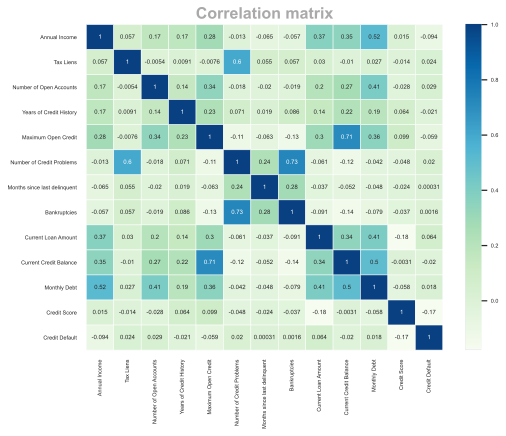

In [50]:
plt.figure(figsize = (8, 6))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontdict=title_font)

plt.show()

### Обзор категориальных переменных

#### Обучающий датасет

In [51]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [52]:
df_train['Term binary'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [53]:
df_train['Home Ownership digit'] = df_train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

In [54]:
obj_columns = ['Years in current job', 'Purpose']

In [55]:
train_dummies = pd.get_dummies(df_train[obj_columns])
df_train = pd.concat([df_train, train_dummies], axis=1)

In [56]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Term binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,46.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,31.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,31.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,46.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,31.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_train.shape

(7500, 45)

#### Тестовый датасет

In [58]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    896
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving               

In [59]:
df_test['Term binary'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [60]:
df_test['Home Ownership digit'] = df_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

In [61]:
test_dummies = pd.get_dummies(df_test[obj_columns])
df_test = pd.concat([df_test, test_dummies], axis=1)

In [62]:
df_test['renewable_energy'] = 0

In [63]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Term binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,renewable_energy
0,Rent,1163968.5,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,727.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,31.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,31.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  2500 non-null   object 
 1   Annual Income                   2500 non-null   float64
 2   Years in current job            2500 non-null   object 
 3   Tax Liens                       2500 non-null   float64
 4   Number of Open Accounts         2500 non-null   float64
 5   Years of Credit History         2500 non-null   float64
 6   Maximum Open Credit             2500 non-null   float64
 7   Number of Credit Problems       2500 non-null   float64
 8   Months since last delinquent    2500 non-null   float64
 9   Bankruptcies                    2500 non-null   float64
 10  Purpose                         2500 non-null   object 
 11  Term                            2500 non-null   object 
 12  Current Loan Amount             25

#### Сохраняю датасеты

In [65]:
df_train.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

In [66]:
DATASET_PATH = 'datasets/course_project_train.csv'
PREP_DATASET_PATH = 'datasets/course_project_train_prepared.csv'

In [67]:
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Term binary,Home Ownership digit,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,46.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,31.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,31.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,46.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,31.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [68]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

### Анализ целевой переменной

**Обзор распределения**

In [69]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

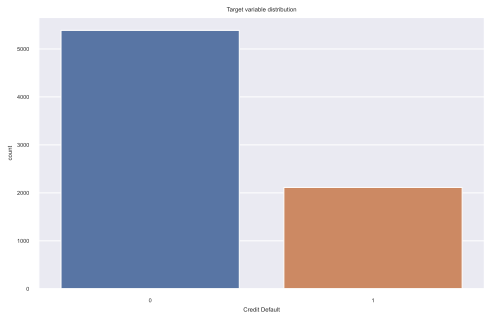

In [70]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

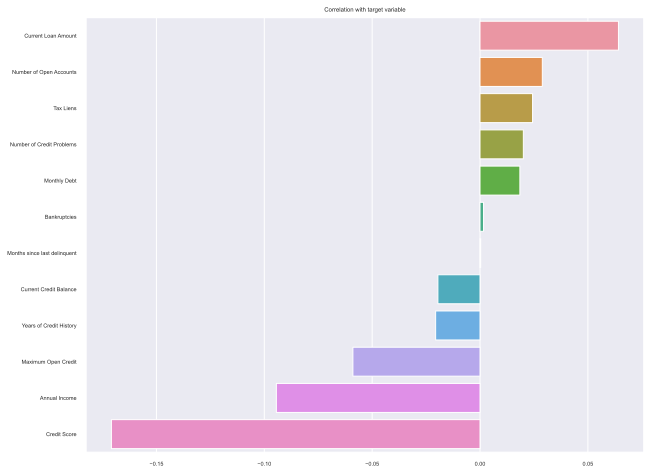

In [71]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

На основании этого графика, принял решение произвести оценку признаков с корреляцией более 0.05 по модулю.

**Оценка признака "Credit Score" в разрезе целевой переменной**

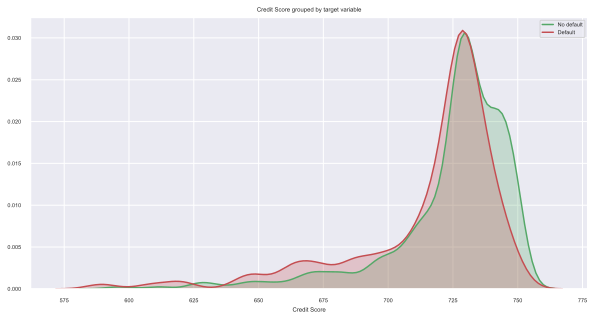

In [72]:
credit_score_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Credit Score" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [73]:
shapiro(credit_score_s)

ShapiroResult(statistic=0.7888856530189514, pvalue=4.490483469879662e-34)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

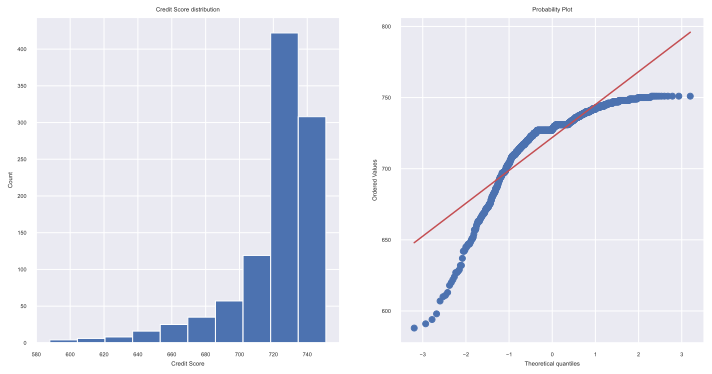

In [74]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [75]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=75889.5, pvalue=3.4123732967777675e-08)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

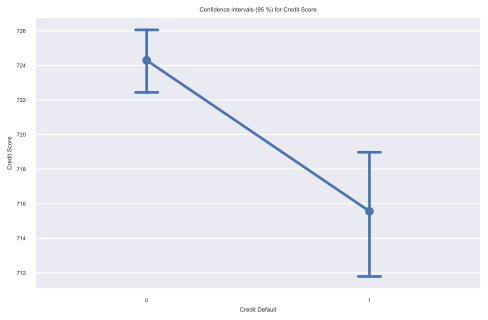

In [76]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

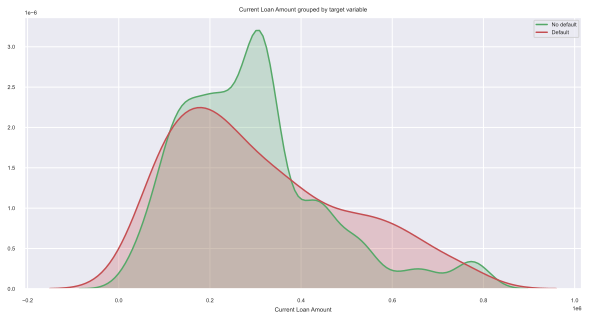

In [77]:
loan_amount_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
loan_amount_s = loan_amount_with_target_s['Current Loan Amount']
loan_amount_target_0 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 0]
loan_amount_target_1 = loan_amount_s[loan_amount_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(loan_amount_target_0, shade=True, label='No default', color='g')
sns.kdeplot(loan_amount_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Current Loan Amount" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [78]:
shapiro(loan_amount_s)

ShapiroResult(statistic=0.9329165816307068, pvalue=8.949970635408017e-21)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

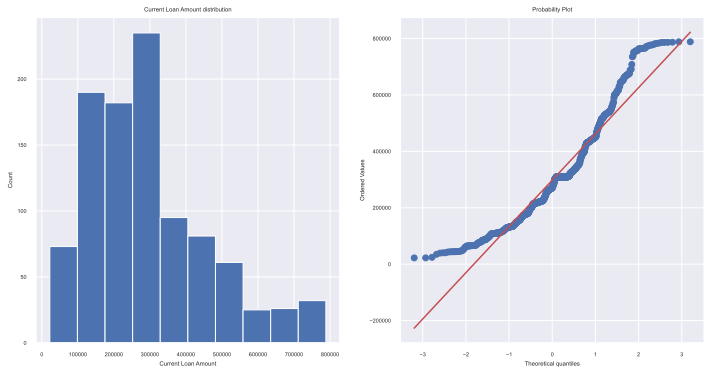

In [79]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
loan_amount_s.hist()

plt.subplot(122)
probplot(loan_amount_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [80]:
mannwhitneyu(loan_amount_target_0, loan_amount_target_1)

MannwhitneyuResult(statistic=98779.0, pvalue=0.24112199658138178)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

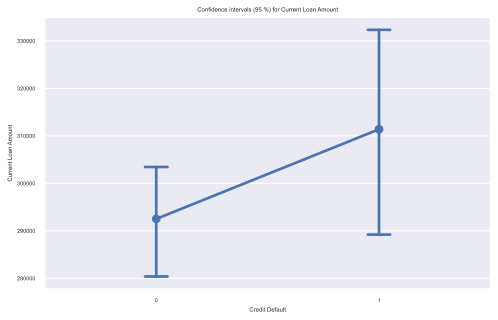

In [81]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=loan_amount_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Annual Income" в разрезе целевой переменной**

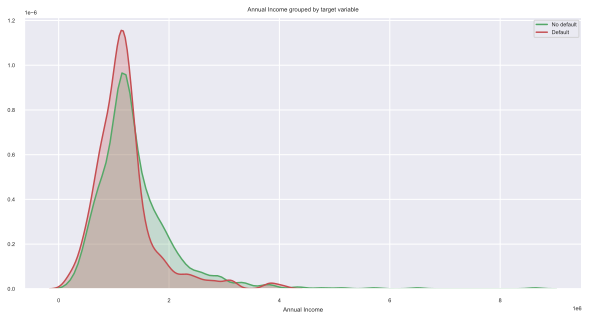

In [82]:
annual_income_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Annual Income" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [83]:
shapiro(annual_income_s)

ShapiroResult(statistic=0.79176926612854, pvalue=6.798703462608499e-34)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

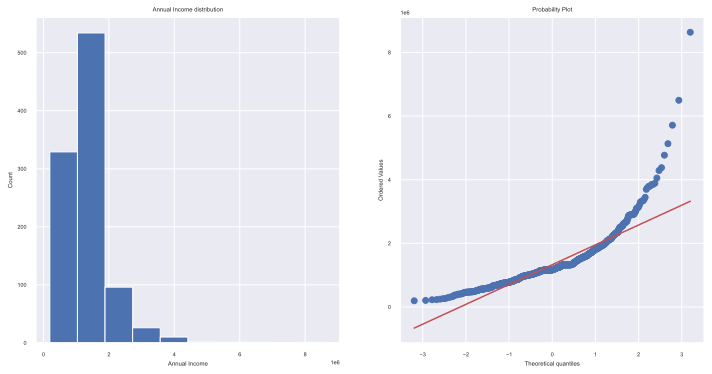

In [84]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [85]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=84001.0, pvalue=1.3656737732085711e-05)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

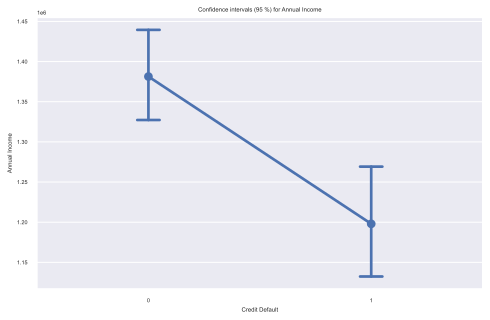

In [86]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

График показывает, что интервалы имеют незначительное пересечение. Однако степеньиз взаимного пересечения менее установлененого в гипотизе уровня значимости, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Maximum Open Credit" в разрезе целевой переменной**

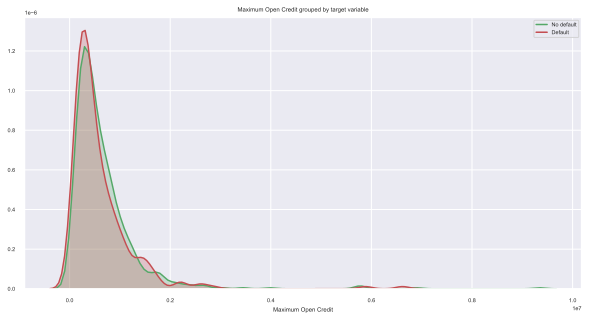

In [87]:
max_credit_with_target_s = df[['Maximum Open Credit', TARGET_NAME]].sample(1000)
max_credit_s = max_credit_with_target_s['Maximum Open Credit']
max_credit_target_0 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 0]
max_credit_target_1 = max_credit_s[max_credit_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(max_credit_target_0, shade=True, label='No default', color='g')
sns.kdeplot(max_credit_target_1, shade=True, label='Default', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.show()

**Наблюдение**  
Есть вероятность, что между признаком "Maximum Open Credit" и целевой переменной существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [88]:
shapiro(max_credit_s)

ShapiroResult(statistic=0.5964192748069763, pvalue=3.965674654039232e-43)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

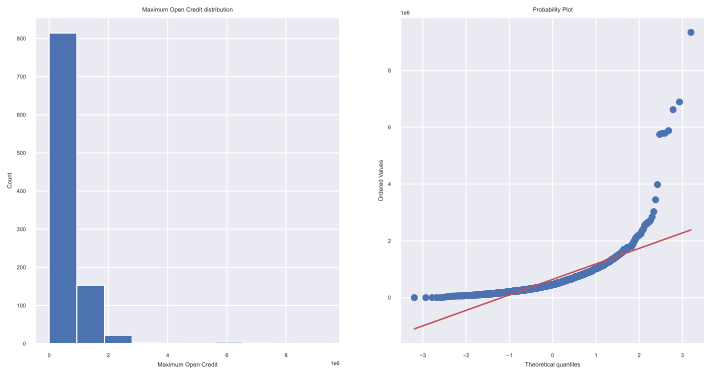

In [89]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Maximum Open Credit')
ax1.set_ylabel('Count')
ax1.set_title('Maximum Open Credit distribution')
max_credit_s.hist()

plt.subplot(122)
probplot(max_credit_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [90]:
mannwhitneyu(max_credit_target_0, max_credit_target_1)

MannwhitneyuResult(statistic=90356.0, pvalue=0.014548387732410442)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравним их для дополнительной проверки.*

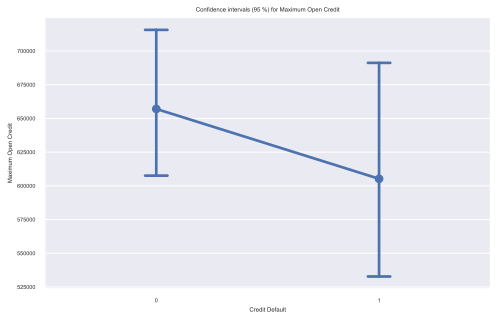

In [91]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=max_credit_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разельтаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

**Матрица корреляций**

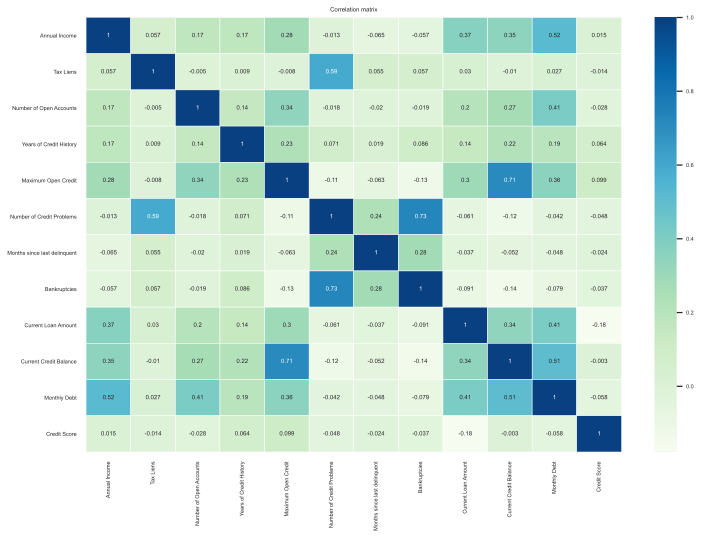

In [92]:
plt.figure(figsize = (12,8))

sns.set(font_scale=0.5)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7500 non-null   object 
 1   Annual Income                   7500 non-null   float64
 2   Years in current job            7500 non-null   object 
 3   Tax Liens                       7500 non-null   float64
 4   Number of Open Accounts         7500 non-null   float64
 5   Years of Credit History         7500 non-null   float64
 6   Maximum Open Credit             7500 non-null   float64
 7   Number of Credit Problems       7500 non-null   float64
 8   Months since last delinquent    7500 non-null   float64
 9   Bankruptcies                    7500 non-null   float64
 10  Purpose                         7500 non-null   object 
 11  Term                            7500 non-null   object 
 12  Current Loan Amount             75

In [94]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [95]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных

In [96]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [97]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и valid

In [103]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=27)

### Балансировка целевой переменной

In [104]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4305
1    3390
Name: Credit Default, dtype: int64

In [105]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и валидационного датасетов

train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

**Логистическая регрессия**

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

**k ближайших соседей**

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_valid_pred = model_knn.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

**XGBoost**

model_xgb = xgb.XGBClassifier(random_state=27)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

**LightGBM**

model_lgbm = lgbm.LGBMClassifier(random_state=27)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

**CatBoost**

model_catb = catb.CatBoostClassifier(silent=True, random_state=27)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

### Выбор лучшей модели и подбор гиперпараметров

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=27)

**Подбор гиперпараметров**

params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

cv=KFold(n_splits=3, random_state=27, shuffle=True)

%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

rs.best_params_

rs.best_score_

### Обучение и оценка финальной модели

In [106]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=3,
                                      silent=True, random_state=27)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      4305
           1       0.71      0.66      0.68      3390

    accuracy                           0.73      7695
   macro avg       0.73      0.72      0.72      7695
weighted avg       0.73      0.73      0.73      7695

VALID

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1082
           1       0.44      0.52      0.47       418

    accuracy                           0.68      1500
   macro avg       0.62      0.63      0.62      1500
weighted avg       0.70      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               805  277
1               202  216
Wall time: 4.12 s
